In [1]:
using BlockBandedMatrices, BandedMatrices, ArrayLayouts, FillArrays, LazyBandedMatrices, LazyArrays
using Plots

In [2]:
function ftest(x, y)
    amp = 1.0
    beta = 2.0
    sigma = 5.0
    nx = length(x)
    ny = length(y)
    f = Array{Float64,2}(undef,nx,ny)
    dxf = similar(f)
    dyf = similar(f)
    for j=1:ny
        for i = 1:nx
            f[i,j] = amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*sin(beta*x[i])
            dxf[i,j] = amp*beta*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*cos(beta*x[i]) - (4.0*amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*x[i]*sin(beta*x[i]))/sigma
            dyf[i,j] = (-2.0*amp*exp((-2.0*x[i]^2 - y[j]^2)/sigma)*y[j]*sin(beta*x[i]))/sigma
        end
    end
    return f, dxf, dyf
end

ftest (generic function with 1 method)

In [3]:
function dP6(n, h)
    
    #A = BandedMatrix{Float64}(undef, (n,n), (2,2))
    A = BandedMatrix(Ones(n,n), (2,2))
    alpha = 17.0/57.0
    beta = -1.0/114.0
    A[band(1)] .= alpha
    A[band(2)] .= beta
    A[band(-1)] .= alpha
    A[band(-2)] .= beta
    A[1,2] = 8.0
    A[1,3] = 6.0
    A[n,n-2] = 6.0
    A[n,n-1] = 8.0

    B = BandedMatrix(Zeros(n,n), (5,5))
    hm1 = 1.0/h
    a = 30.0/19.0
    t1 = a*(0.5*hm1)
    B[band(-1)]  .= -t1
    B[band(1)] .= t1
    
    a = -43.0/12.0*hm1
    b = -20.0/3.0*hm1
    c = 9.0*hm1
    d = 4.0/3.0*hm1
    e = -1.0/12.0*hm1
    
    B[1,1] = a
    B[1,2] = b
    B[1,3] = c
    B[1,4] = d
    B[1,5] = e

    B[n,n-4] = -e
    B[n,n-3] = -d
    B[n,n-2] = -c
    B[n,n-1] = -b
    B[n,n] = -a
    
    return A, B
end

dP6 (generic function with 1 method)

In [4]:
nx = 51
ny = 51
x1 = LinRange(-2.0, 2.0, nx)
y1 = LinRange(-2.0, 2.0, ny)
fe, dxfe, dyfe = ftest(x1, y1)
hx = x1[2] - x1[1]
hy = y1[2] - y1[1]

0.08000000000000007

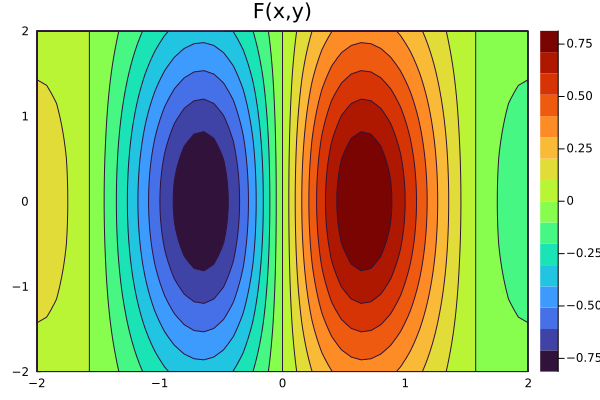

In [5]:
#heatmap(f1)
contour(x1, y1, fe',fill=true, color=:turbo, title="F(x,y)")

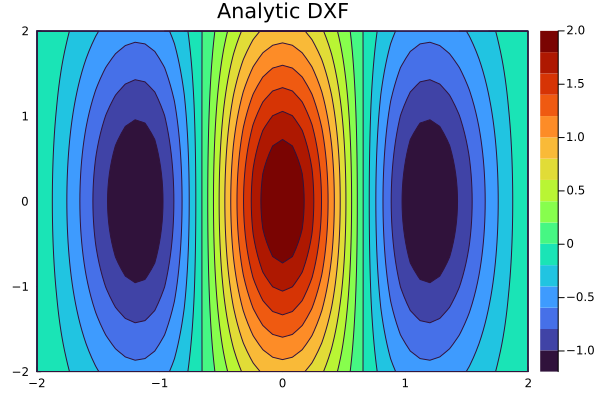

In [6]:
contour(x1, y1, dxfe',fill=true, color=:turbo, title="Analytic DXF")

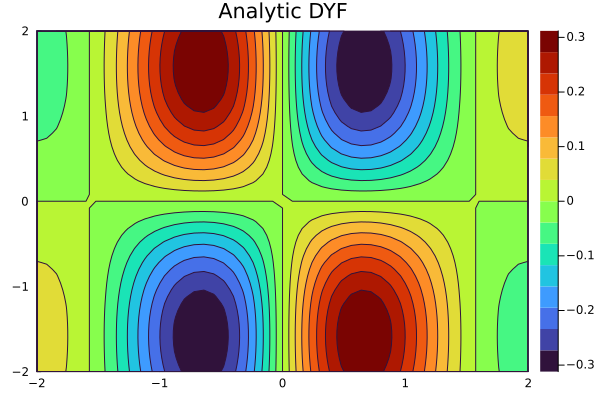

In [7]:
contour(x1, y1, dyfe',fill=true, color=:turbo, title="Analytic DYF")

In [8]:
Ap6x, Bp6x = dP6(nx, hx)
Dp6x = Ap6x \ Bp6x;

In [9]:
Ap6y, Bp6y = dP6(ny, hy)
Dp6y = Ap6y \ Bp6y;

In [10]:
Dp6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), Dp6x))
Dp6y_2d = BandedBlockBandedMatrix(Kron(Dp6y, Eye(nx)));

In [11]:
f1d = vec(fe)
dxf1d = Dp6x_2d*f1d;
dyf1d = Dp6y_2d*f1d;

In [12]:
dxf = reshape(dxf1d,nx,ny);
dyf = reshape(dyf1d,nx,ny);

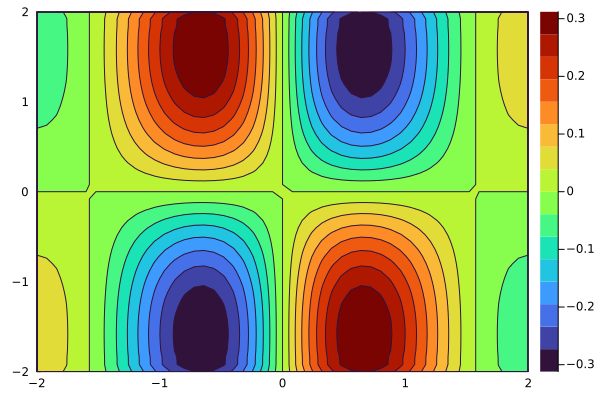

In [13]:
contour(x1, y1, dyf', fill=true, color=:turbo)

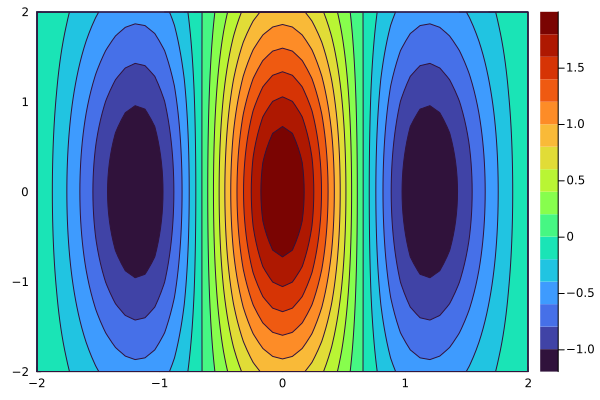

In [14]:
contour(x1, y1, dxf', fill=true, color=:turbo)

In [15]:
ww = Array{Int64,2}(undef,5,5)
for j = 1:5
    for i = 1:5
        ww[i,j] = (i-1) + 10*(j-1)
    end
end

In [16]:
px = zeros(5,5)
for i = 1:5
    k = i+1 
    if k<6; px[i,k] = 0.5 end
    k = i-1
    if k > 0; px[i,k] = -0.5 end
end
px[1,1] = -1.0
px[1,2] = 1.0
px[5,4] = -1.0
px[5,5] = 1.0
ident = zeros(5,5)
for i = 1:5
    ident[i,i] = 1.0
end
px

5×5 Matrix{Float64}:
 -1.0   1.0   0.0   0.0  0.0
 -0.5   0.0   0.5   0.0  0.0
  0.0  -0.5   0.0   0.5  0.0
  0.0   0.0  -0.5   0.0  0.5
  0.0   0.0   0.0  -1.0  1.0

In [17]:
include("compactFD.jl")

filterT8 (generic function with 1 method)

In [18]:
Px, Qx = derivKim4(nx,hx)
Dk6x = Px \ Qx;
Py, Qy = derivKim4(ny,hy)
Dk6y = Py \ Qy;

In [19]:
Pfx, Qfx = filterKim6(nx)
Pfy, Qfy = filterKim6(ny)
F6x = Pfx \ Qfx
F6y = Pfy \ Qfy;

In [20]:
Dk6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), Dk6x))
Dk6y_2d = BandedBlockBandedMatrix(Kron(Dk6y, Eye(nx)));

In [21]:
dkxf1d = Dk6x_2d*f1d;
dkyf1d = Dk6y_2d*f1d;

In [22]:
dkxf = reshape(dkxf1d,nx,ny);
dkyf = reshape(dkyf1d,nx,ny);

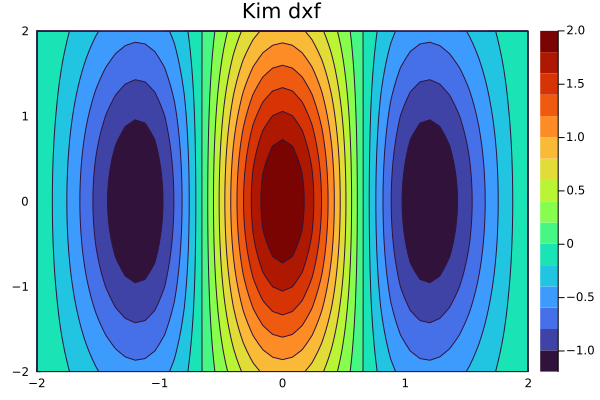

In [23]:
contour(x1, y1, dkxf', fill=true, color=:turbo, title="Kim dxf")

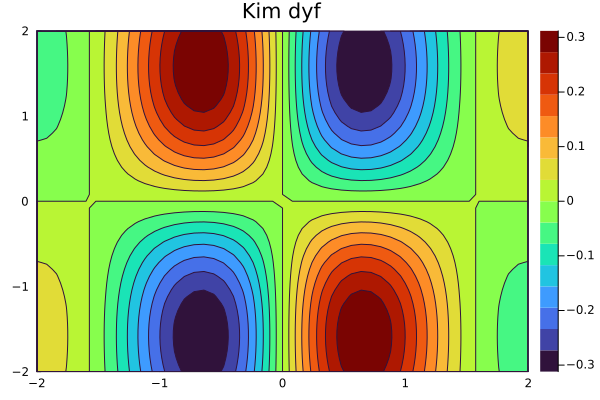

In [24]:
contour(x1, y1, dkyf', fill=true, color=:turbo, title="Kim dyf")

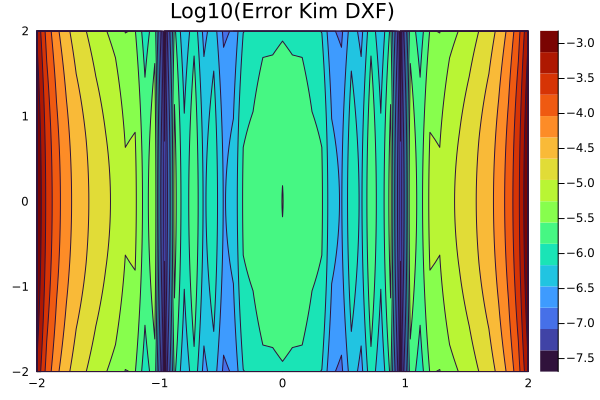

In [25]:
dkxferr = similar(dkxf)
@. dkxferr = log10(abs(dkxf - dxfe))
contour(x1, y1, dkxferr', fill=true, color=:turbo, title="Log10(Error Kim DXF)")

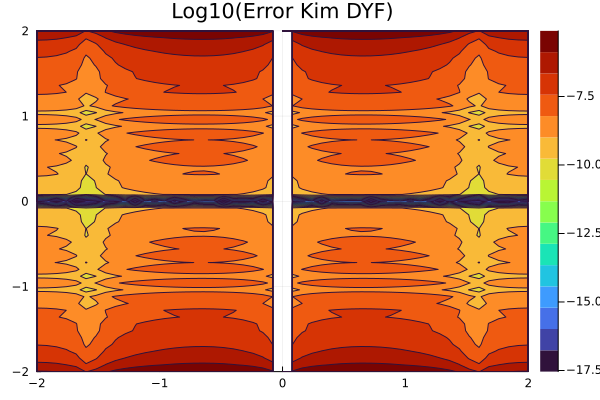

In [26]:
dkyferr = similar(dkyf)
@. dkyferr = log10(abs(dkyf - dyfe))
contour(x1, y1, dkyferr', fill=true, color=:turbo, title="Log10(Error Kim DYF)")

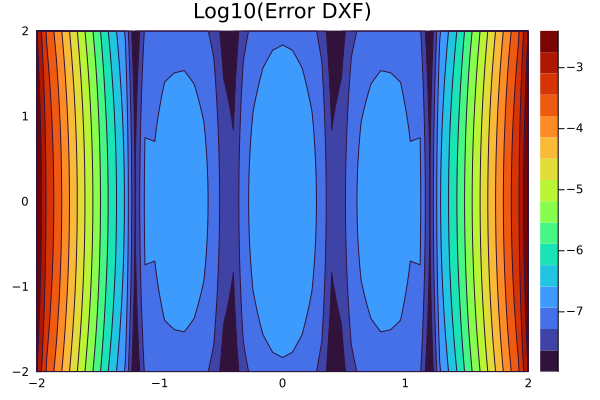

In [27]:
dxferr = similar(dxf)
@. dxferr = log10(abs(dxf - dxfe))
contour(x1, y1, dxferr', fill=true, color=:turbo, title="Log10(Error DXF)")

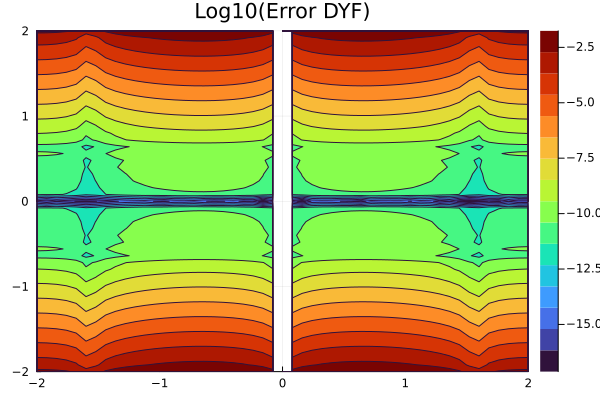

In [28]:
dyferr = similar(dyf)
@. dyferr = log10(abs(dyf - dyfe))
contour(x1, y1, dyferr', fill=true, color=:turbo, title="Log10(Error DYF)")

In [29]:
Sx, Tx = derivBLT6(nx,hx)
L6x = Sx \ Tx;
Sy, Ty = derivBLT6(ny,hy)
L6y = Sy \ Ty;

In [30]:
L6x_2d = BandedBlockBandedMatrix(Kron(Eye(ny), L6x))
L6y_2d = BandedBlockBandedMatrix(Kron(L6y, Eye(nx)));

In [31]:
dlxf1d = L6x_2d*f1d;
dlyf1d = L6y_2d*f1d;

In [32]:
dlxf = reshape(dlxf1d,nx,ny);
dlyf = reshape(dlyf1d,nx,ny);

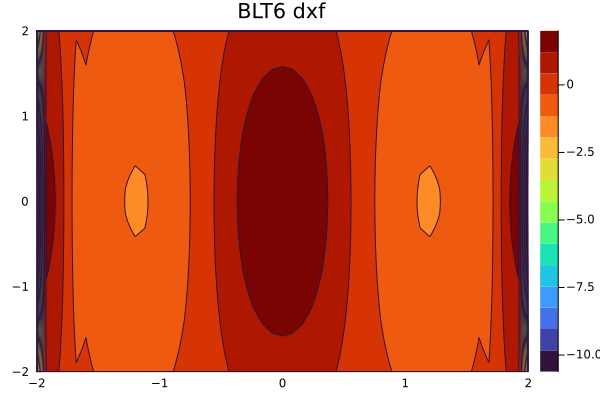

In [33]:
contour(x1, y1, dlxf', fill=true, color=:turbo, title="BLT6 dxf")

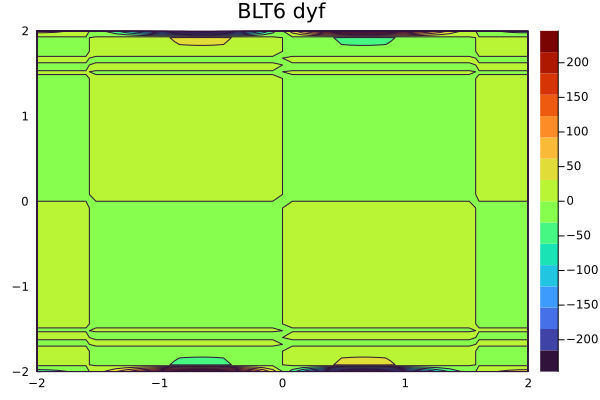

In [34]:
contour(x1, y1, dlyf', fill=true, color=:turbo, title="BLT6 dyf")

In [35]:
Sx, Tx = derivBLT6(11,hx)

([1.0 6.85667616635778 … 0.0 0.0; 0.41230047387468755 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.41230047387468755; 0.0 0.0 … 6.85667616635778 1.0], [-45.68335708256107 -30.35082308609491 … 0.0 0.0; -13.0450313967899 0.0 … 0.0 0.0; … ; 0.0 0.0 … -0.0 13.0450313967899; 0.0 0.0 … 30.35082308609491 45.68335708256107])

In [36]:
Sx

11×11 BandedMatrix{Float64} with bandwidths (1, 1):
 1.0      6.85668     ⋅          ⋅        …    ⋅          ⋅         ⋅ 
 0.4123   1.0        1.95634     ⋅             ⋅          ⋅         ⋅ 
  ⋅      -0.479872   1.0       -1.29308        ⋅          ⋅         ⋅ 
  ⋅        ⋅        -0.391778   1.0            ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅         0.333333       ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅        …    ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅             ⋅          ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅           -0.391778    ⋅         ⋅ 
  ⋅        ⋅          ⋅          ⋅            1.0       -0.479872   ⋅ 
  ⋅        ⋅          ⋅          ⋅            1.95634    1.0       0.4123
  ⋅        ⋅          ⋅          ⋅        …    ⋅         6.85668   1.0

In [37]:
Tx

11×11 BandedMatrix{Float64} with bandwidths (5, 5):
 -45.6834    -30.3508   108.917     …      ⋅          ⋅         ⋅ 
 -13.045       0.0       -8.92019          ⋅          ⋅         ⋅ 
   2.36346    -3.7926     0.0              ⋅          ⋅         ⋅ 
  -0.679792    5.69537  -11.2329          0.0         ⋅         ⋅ 
   0.0         0.0       -0.347222        0.0        0.0        ⋅ 
   0.0         0.0        0.0       …     0.0        0.0       0.0
    ⋅          0.0        0.0             0.347222   0.0       0.0
    ⋅           ⋅         0.0            11.2329    -5.69537   0.679792
    ⋅           ⋅          ⋅             -0.0        3.7926   -2.36346
    ⋅           ⋅          ⋅              8.92019   -0.0      13.045
    ⋅           ⋅          ⋅        …  -108.917     30.3508   45.6834

In [38]:
Px, Qx = derivKim4(11,hx)

([1.0 5.912678614078549 … 0.0 0.0; 0.08360703307833438 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.08360703307833438; 0.0 0.0 … 5.912678614078549 1.0], [-40.50851954340612 -43.210977283045075 … 0.0 0.0; -3.971809113403273 -18.360338111180763 … 0.0 0.0; … ; 0.0 0.0 … 18.360338111180763 3.971809113403273; 0.0 0.0 … 43.210977283045075 40.50851954340612])

In [39]:
Px

11×11 BandedMatrix{Float64} with bandwidths (2, 2):
 1.0        5.91268    3.77562    …   ⋅          ⋅          ⋅ 
 0.083607   1.0        2.0581         ⋅          ⋅          ⋅ 
 0.0325001  0.399804   1.0            ⋅          ⋅          ⋅ 
  ⋅         0.0954953  0.58627        ⋅          ⋅          ⋅ 
  ⋅          ⋅         0.0954953      ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.0954953   ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.58627    0.0954953   ⋅ 
  ⋅          ⋅          ⋅            1.0        0.399804   0.0325001
  ⋅          ⋅          ⋅            2.0581     1.0        0.083607
  ⋅          ⋅          ⋅         …  3.77562    5.91268    1.0

In [40]:
Qx

11×11 BandedMatrix{Float64} with bandwidths (6, 6):
 -40.5085     -43.211      72.988      …     ⋅           ⋅           ⋅ 
  -3.97181    -18.3603     -0.350954         ⋅           ⋅           ⋅ 
  -1.52376     -7.87706    -3.8995          0.0          ⋅           ⋅ 
  -0.0892619   -3.23251    -8.03926         0.0         0.0          ⋅ 
   0.0         -0.0892619  -3.23251         0.0         0.0         0.0
   0.0          0.0        -0.0892619  …    0.0892619   0.0         0.0
   0.0          0.0         0.0             3.23251     0.0892619   0.0
    ⋅           0.0         0.0             8.03926     3.23251     0.0892619
    ⋅            ⋅          0.0             3.8995      7.87706     1.52376
    ⋅            ⋅           ⋅              0.350954   18.3603      3.97181
    ⋅            ⋅           ⋅         …  -72.988      43.211      40.5085

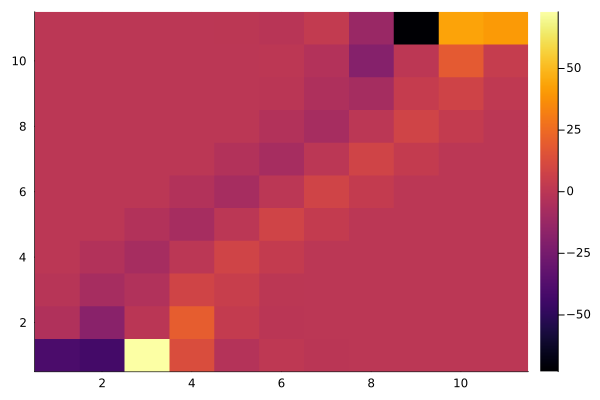

In [41]:
heatmap(Qx)

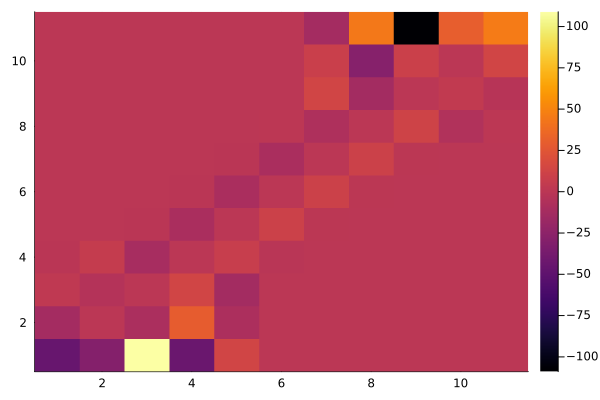

In [42]:
heatmap(Tx)

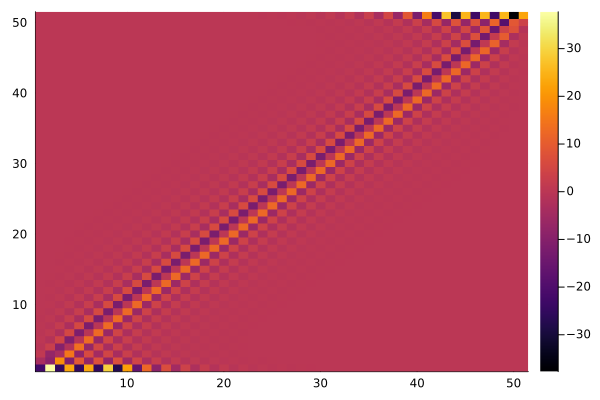

In [43]:
heatmap(Dk6x)

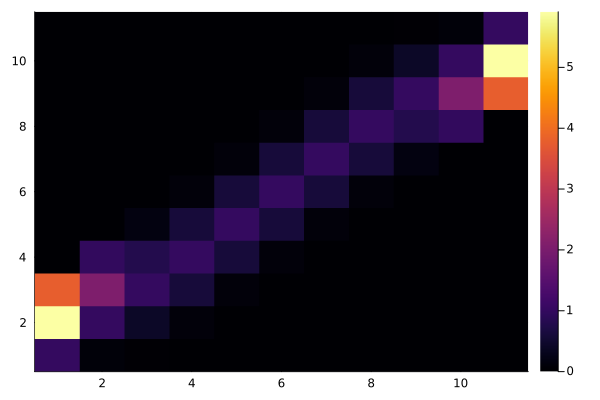

In [44]:
heatmap(Px')

In [45]:
q1 = similar(x1)
@. q1 = sin(x1)


51-element Vector{Float64}:
 -0.9092974268256817
 -0.9396454736853249
 -0.9639829961524482
 -0.9821543171376185
 -0.994043202198076
 -0.9995736030415051
 -0.998710143975583
 -0.9914583481916864
 -0.9778646024353161
 -0.958015860289225
 -0.9320390859672264
 -0.9001004421765051
 -0.8624042272433384
  ⋮
  0.9001004421765051
  0.9320390859672264
  0.9580158602892249
  0.9778646024353161
  0.9914583481916864
  0.998710143975583
  0.9995736030415051
  0.994043202198076
  0.9821543171376185
  0.9639829961524482
  0.9396454736853249
  0.9092974268256817

In [46]:
dkq = Dk6x*q1
dLq = L6x*q1

51-element Vector{Float64}:
 504.74438618170274
 -74.27668910175139
 -68.31300437266697
 -26.553108408950024
   9.961559193080538
  -3.875805788137394
   1.5200473371397072
  -0.4307885820758093
   0.4236026860457933
   0.20483543985224745
   0.393633043482565
   0.4237363488126969
   0.5107832603471368
   ⋮
   0.4237363488126989
   0.39363304348256445
   0.20483543985224376
   0.4236026860457979
  -0.43078858207580795
   1.5200473371397012
  -3.8758057881373724
   9.96155919308048
 -26.553108408949857
 -68.31300437266655
 -74.27668910175096
 504.74438618169967

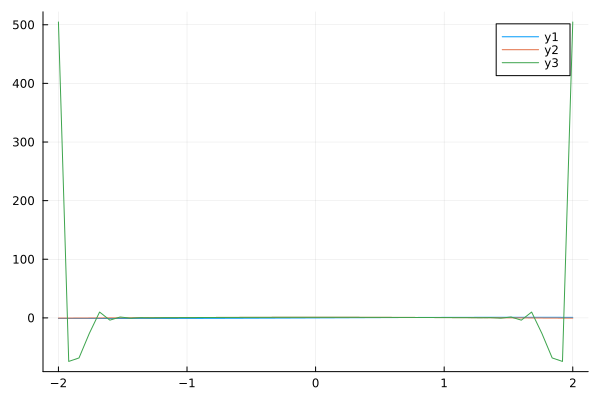

In [47]:
plot(x1,q1)
plot!(x1,dkq)
plot!(x1,dLq)
#plot!(x1,dLq,xrange=(-1,1),yrange=(-1.2,1.2))

In [48]:
typeof(Dk6x_2d)

BandedBlockBandedMatrix{Float64, BlockArrays.PseudoBlockMatrix{Float64, Matrix{Float64}, Tuple{BlockArrays.BlockedUnitRange{StepRange{Int64, Int64}}, Base.OneTo{Int64}}}, Base.OneTo{Int64}}

In [49]:
typeof(Dk6x)

Matrix{Float64} (alias for Array{Float64, 2})

In [50]:
Dk6x

51×51 Matrix{Float64}:
 -22.6861      37.7234      -25.2572      …    3.74737e-5  -6.75815e-6
  -3.62712     -8.98397      18.9323          -9.4825e-6    1.71011e-6
   0.959734    -7.36699      -3.62729          4.92455e-6  -8.88113e-7
  -0.436107     2.71198     -10.0022          -3.90126e-6   7.03569e-7
   0.249528    -1.46134       4.306            4.05853e-6  -7.31931e-7
  -0.164785     0.934288     -2.54336     …   -4.81407e-6   8.68187e-7
   0.116316    -0.650405      1.7067           6.08128e-6  -1.09672e-6
  -0.0843126    0.468949     -1.21268         -7.93811e-6   1.43159e-6
   0.0617246   -0.342642      0.881232         1.0549e-5   -1.90244e-6
  -0.045352     0.251576     -0.645735        -1.41576e-5   2.55323e-6
   0.0333658   -0.185039      0.474609    …    1.91042e-5  -3.44532e-6
  -0.024559     0.136186     -0.349216        -2.58559e-5   4.66295e-6
   0.0180798   -0.100254      0.257053         3.50507e-5  -6.32117e-6
   ⋮                                      ⋱           

In [51]:
Px

11×11 BandedMatrix{Float64} with bandwidths (2, 2):
 1.0        5.91268    3.77562    …   ⋅          ⋅          ⋅ 
 0.083607   1.0        2.0581         ⋅          ⋅          ⋅ 
 0.0325001  0.399804   1.0            ⋅          ⋅          ⋅ 
  ⋅         0.0954953  0.58627        ⋅          ⋅          ⋅ 
  ⋅          ⋅         0.0954953      ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅         …   ⋅          ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.0954953   ⋅          ⋅ 
  ⋅          ⋅          ⋅            0.58627    0.0954953   ⋅ 
  ⋅          ⋅          ⋅            1.0        0.399804   0.0325001
  ⋅          ⋅          ⋅            2.0581     1.0        0.083607
  ⋅          ⋅          ⋅         …  3.77562    5.91268    1.0

In [52]:
Qx

11×11 BandedMatrix{Float64} with bandwidths (6, 6):
 -40.5085     -43.211      72.988      …     ⋅           ⋅           ⋅ 
  -3.97181    -18.3603     -0.350954         ⋅           ⋅           ⋅ 
  -1.52376     -7.87706    -3.8995          0.0          ⋅           ⋅ 
  -0.0892619   -3.23251    -8.03926         0.0         0.0          ⋅ 
   0.0         -0.0892619  -3.23251         0.0         0.0         0.0
   0.0          0.0        -0.0892619  …    0.0892619   0.0         0.0
   0.0          0.0         0.0             3.23251     0.0892619   0.0
    ⋅           0.0         0.0             8.03926     3.23251     0.0892619
    ⋅            ⋅          0.0             3.8995      7.87706     1.52376
    ⋅            ⋅           ⋅              0.350954   18.3603      3.97181
    ⋅            ⋅           ⋅         …  -72.988      43.211      40.5085

In [53]:
FDx = Px\Qx

11×11 Matrix{Float64}:
 -22.4695    36.5503    -22.4512   …  -17.3071     7.28355   -1.3478
  -3.68222   -8.6856     18.2186        4.47567   -1.8649     0.343985
   0.988645  -7.52355    -3.25286      -2.42504    0.991366  -0.181711
  -0.459308   2.83762   -10.3027        2.02216   -0.808308   0.147032
   0.274039  -1.59406     4.62334      -2.23052    0.869694  -0.156826
  -0.194701   1.09626    -2.93051  …    2.93051   -1.09626    0.194701
   0.156826  -0.869694    2.23052      -4.62334    1.59406   -0.274039
  -0.147032   0.808308   -2.02216      10.3027    -2.83762    0.459308
   0.181711  -0.991366    2.42504       3.25286    7.52355   -0.988645
  -0.343985   1.8649     -4.47567     -18.2186     8.6856     3.68222
   1.3478    -7.28355    17.3071   …   22.4512   -36.5503    22.4695